In [2]:
#Імпортуємо всі необхідні бібліотеки
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')


In [3]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8, 8))

# Список інструментів
instruments = 'sax flute viola cello trumpet oboe'.split()

# Шлях до аудіофайлів
base_path = r'E:\Windows Kits\analis\audio\london_phill_dataset_multi'

# Створення спектрограм для кожного інструмента
for instrument in instruments:
    instrument_path = os.path.join(base_path, instrument)
    output_path = os.path.join('img_data', instrument)
    pathlib.Path(output_path).mkdir(parents=True, exist_ok=True)
    
    for filename in os.listdir(instrument_path):
        audioname = os.path.join(instrument_path, filename)
        try:
            y, sr = librosa.load(audioname, mono=True, duration=5)
            plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB')
            plt.axis('off')
            plt.savefig(os.path.join(output_path, f'{filename[:-4]}.png'))
            plt.clf()
        except Exception as e:
            print(f"Error loading {audioname}. Error: {e}")


<Figure size 800x800 with 0 Axes>

In [4]:
#Створюємо файл CSV для збереження в нього даних
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [5]:
csv_file_path = r'dataset.csv'

# Створення заголовка для CSV файлу
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# Запис заголовка у CSV файл
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)

instruments = 'sax flute viola cello trumpet oboe'.split()

# Отримання ознак та запис у CSV файл
for instrument in instruments:
    instrument_path = os.path.join(base_path, instrument)
    for filename in os.listdir(instrument_path):
        audioname = os.path.join(instrument_path, filename)
        try:
            y, sr = librosa.load(audioname, mono=True, duration=30)
            rmse = librosa.feature.rms(y=y)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {instrument}'
            with open(csv_file_path, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())
        except Exception as e:
            print(f"Error processing {audioname}. Error: {e}")


In [6]:
# Обробка даних
data = pd.read_csv(csv_file_path)
print(data.head())

# Видалення непотрібних стовпчиків
data = data.drop(['filename'], axis=1)

# Створення міток
instrument_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(instrument_list)

# Масштабування стовпчиків ознак
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

# Розділення даних на навчальний та тестовий набір
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Перевірка результатів
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

                                  filename  chroma_stft      rmse  \
0        saxophone_A3_025_forte_normal.mp3     0.322156  0.026990   
1   saxophone_A3_025_fortissimo_normal.mp3     0.331868  0.030299   
2  saxophone_A3_025_mezzo-piano_normal.mp3     0.301408  0.023705   
3   saxophone_A3_025_pianissimo_normal.mp3     0.303428  0.025234   
4         saxophone_A3_05_forte_normal.mp3     0.246268  0.032016   

   spectral_centroid  spectral_bandwidth      rolloff  zero_crossing_rate  \
0        1708.984682         1888.267560  3552.081299            0.056519   
1        1738.263129         1897.762878  3100.781250            0.075765   
2        1422.253167         1750.194754  2769.323730            0.052909   
3         885.094253         1149.393252  1429.266357            0.059001   
4        1558.447324         1593.848677  3038.424683            0.055318   

        mfcc1       mfcc2      mfcc3  ...     mfcc12    mfcc13    mfcc14  \
0 -446.552002  101.640511 -22.164816  ... -11.

In [7]:
#Створюємо і підлаштовуємо модель ANN
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1977 - loss: 2.2583
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5558 - loss: 1.8050 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7149 - loss: 1.4440 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8054 - loss: 1.1082 
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8929 - loss: 0.7811 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9220 - loss: 0.5512 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9394 - loss: 0.3659 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9494 - loss: 0.2618 
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9658 - loss: 0.1606 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9836 - loss: 0.1184 
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9819 - loss: 0.0951 
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9808 - loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9617 - loss: 0.0648  
Test accuracy: 0.9667
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification Report:
              precision    recall  f1-score   support

       cello       0.94      0.94      0.94        17
       flute       1.00      1.00      1.00        20
        oboe       1.00      0.96      0.98        24
         sax       1.00      0.96      0.98        23
     trumpet       0.89      1.00      0.94        17
       viola       0.95      0.95      0.95        19

    accuracy                           0.97       120
   macro avg       0.96      0.97      0.96       120
weighted avg       0.97      0.97      0.97       120

Confusion Matrix:
[[16  0  0  0  0  1]
 [ 0 20  0  0  0  0]
 [ 0  0 23  0  1  0]
 [ 0  0  0 22  1  0]
 [ 0  0  0  0 17  0]
 [ 1  0  0  0  0 18]]


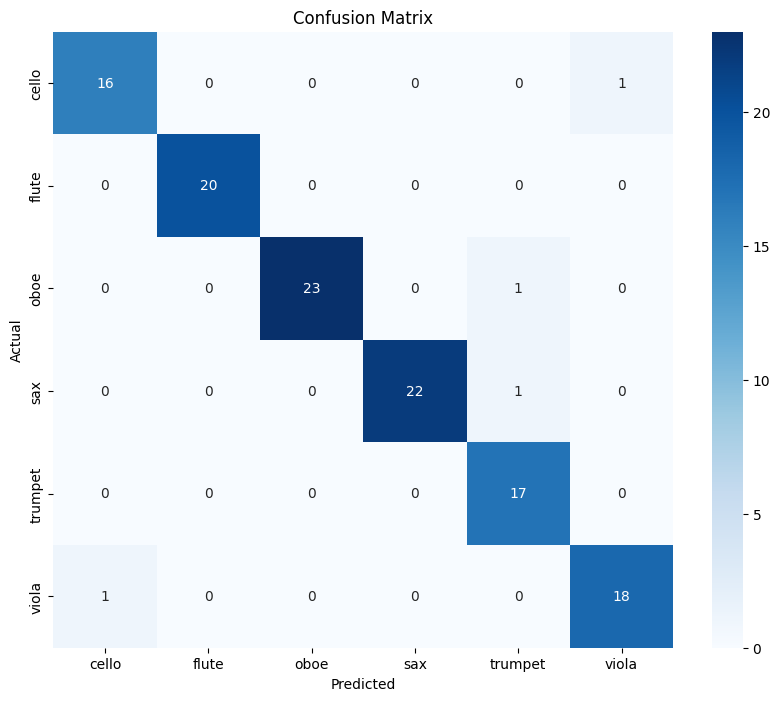

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Оцінка моделі на тестових даних
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

# Прогнозування міток для тестових даних
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Оцінка якості моделі
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Додатковий код для візуалізації матриці плутанини (за бажанням)
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()